In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import argparse
import sys
import librosa


def estimate_tuning(input_file):
    '''Load an audio file and estimate tuning (in cents)'''

    print('Loading ', input_file)
    y, sr = librosa.load(input_file)

    print('Separating harmonic component ... ')
    y_harm = librosa.effects.harmonic(y)

    print('Estimating tuning ... ')
    # Just track the pitches associated with high magnitude
    tuning = librosa.estimate_tuning(y=y_harm, sr=sr)

    print('{:+0.2f} cents'.format(100 * tuning))


def process_arguments(args):
    '''Argparse function to get the program parameters'''

    parser = argparse.ArgumentParser(description='Tuning estimation example')

    parser.add_argument('input_file',
                        action='store',
                        help='path to the input file (wav, mp3, etc)')

    return vars(parser.parse_args(args))

In [3]:
from librosa import sequence

In [4]:
real_labels = ['C:maj', 'C#:maj', 'D:maj', 'D#:maj', 'E:maj', 'G:maj', 'G#:maj', 'A:maj', 'A#:maj',
             'C:min', 'C#:min', 'D:min', 'D#:min', 'E:min', 'G:min', 'G#:min', 'A:min', 'A#:min']
map_labels ={
    'C:maj' : 'c',
    'C#:maj': 'c',
    'D:maj' : 'dm', 
    'D#:maj' : 'dm', 
    'E:maj' : 'e', 
    'G:maj' : 'g', 
    'G#:maj' : 'g', 
    'A:maj': 'am', 
    'A#:maj' : 'am',
    'C:min' : 'c', 
    'C#:min': 'c', 
    'D:min' : 'dm', 
    'D#:min' : 'dm',
    'E:min' : 'e',
    'G:min': 'g', 
    'G#:min': 'g',
    'A:min' : 'am',
    'A#:min' : 'am'
}

In [18]:
def get_chord(input_file):
    #print(input_file)
    import numpy as np
    from librosa import display
    #input_file = 'samples/e0.wav'
    # Create templates for major, minor, and no-chord qualities
    maj_template = np.array([1,0,0, 0,1,0, 0,1,0, 0,0,0])
    min_template = np.array([1,0,0, 1,0,0, 0,1,0, 0,0,0])
    N_template   = np.array([1,1,1, 1,1,1, 1,1,1, 1,1,1.]) / 4.
    # Generate the weighting matrix that maps chroma to labels
    weights = np.zeros((25, 12), dtype=float)
    labels = ['C:maj', 'C#:maj', 'D:maj', 'D#:maj', 'E:maj', 'F:maj',
               'F#:maj', 'G:maj', 'G#:maj', 'A:maj', 'A#:maj', 'B:maj',
             'C:min', 'C#:min', 'D:min', 'D#:min', 'E:min', 'F:min',
             'F#:min', 'G:min', 'G#:min', 'A:min', 'A#:min', 'B:min',
             'N']
    for c in range(1):
        weights[c, :] = np.roll(maj_template, c) # c:maj
        weights[c + 12, :] = np.roll(min_template, c)  # c:min
        weights[-1] = N_template  # the last row is the no-chord class
    # Make a self-loop transition matrix over 25 states
        trans = librosa.sequence.transition_loop(25, 0.9)
        # Load in audio and make features
        y, sr = librosa.load(input_file)
        chroma = librosa.feature.chroma_cens(y=y, sr=sr, bins_per_octave=36)
        # Map chroma (observations) to class (state) likelihoods
        probs = np.exp(weights.dot(chroma))  # P[class | chroma] proportional to exp(template' chroma)
        probs /= probs.sum(axis=0, keepdims=True)  # probabilities must sum to 1 in each column
        # Compute independent frame-wise estimates
        chords_ind = np.argmax(probs, axis=0)
        # And viterbi estimates
        chords_vit = librosa.sequence.viterbi_discriminative(probs, trans)
        # Plot the features and prediction map
#         import matplotlib.pyplot as plt
#         plt.figure(figsize=(10, 6))
#         plt.subplot(2,1,1)
#         librosa.display.specshow(chroma, x_axis='time', y_axis='chroma')
#         plt.colorbar()
    #     plt.subplot(2,1,2)
    #     librosa.display.specshow(weights, x_axis='chroma')
    #     plt.yticks(np.arange(25) + 0.5, labels)
    #     plt.ylabel('Chord')
    #     plt.colorbar()
    #     plt.tight_layout()
    #     # And plot the results
    #     plt.figure(figsize=(10, 4))
    #     display.specshow(probs, x_axis='time', cmap='gray')
    #     plt.colorbar()
    #     times = librosa.frames_to_time(np.arange(len(chords_vit)))
    #     plt.scatter(times, chords_ind + 0.75, color='lime', alpha=0.5, marker='+', s=15, label='Independent')
    #     plt.scatter(times, chords_vit + 0.25, color='deeppink', alpha=0.5, marker='o', s=15, label='Viterbi')
    #     plt.yticks(0.5 + np.unique(chords_vit), [labels[i] for i in np.unique(chords_vit)], va='center')
    #     plt.legend(loc='best')
    #     plt.tight_layout()
    sum_ = chroma.sum(axis=1)
    #sum_ = chroma.max(axis=1)
    return sum_
    #print(sum_)
    mask = np.array(sum_ > 0.5).astype(int)
    #print(mask)
    #plt.show()
    return mask
#     while True:
#         max_i = sum_.argmax()
#         if labels[max_i] in real_labels:
#             if map_labels[labels[max_i]] == 'am':
#                 tmp = sorted(sum_)[::-1]
#                 if tmp[0] / tmp[2] < 2.:
#                     return mask, 'D:maj'
#             return mask, labels[max_i]
#         sum_[max_i] = 0.
    #return labels[chroma.sum(axis=1).argmax()]

In [17]:
import pandas as pd
import os
data = pd.read_csv('easy_ans.txt', sep = ' ', dtype='str', header=-1)
data[0] = data[0].apply(lambda x : os.path.join('dataset-easy', x + '.wav'))
data.head()

,0,1
0,dataset-easy/0000.wav,dm
1,dataset-easy/0001.wav,e
2,dataset-easy/0002.wav,c
3,dataset-easy/0003.wav,am
4,dataset-easy/0004.wav,c


In [28]:
print(data.shape)
data = data.drop(961, axis=0)
print(data.shape)

(1000, 2)
(999, 2)


In [30]:
data['features'] = data[0].apply(lambda x : get_chord(x))
data.head()

,0,1,features
0,dataset-easy/0000.wav,dm,"[2.1775387286103833, 3.4027664767860837, 76.01..."
1,dataset-easy/0001.wav,e,"[4.5023759787316475, 0.988520723956416, 1.3793..."
2,dataset-easy/0002.wav,c,"[113.33505252181617, 6.956102734052182, 3.0014..."
3,dataset-easy/0003.wav,am,"[39.98466715474463, 0.5072946371843958, 0.3389..."
4,dataset-easy/0004.wav,c,"[123.81452794914394, 6.058875900498014, 2.3021..."


In [31]:
#data.to_csv('data_easy.csv', index=False)

In [32]:
class2indx = {
    'am' : 0,
    'dm' : 1,
    'c' : 2,
    'e' : 3,
    'g' : 4
}

In [69]:
i2class = {}
for ac in class2indx.keys():
    i2class[class2indx[ac]] = ac

In [70]:
i2class

{0: 'am', 1: 'dm', 2: 'c', 3: 'e', 4: 'g'}

In [34]:
#pd.read_csv('data_easy.csv').head()

In [35]:
data['y'] = data[1].apply(lambda x : class2indx[x])

In [36]:
from sklearn.ensemble import RandomForestClassifier

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [104]:
clf = RandomForestClassifier(n_estimators=80, random_state=42)

In [105]:
X = list(data.features.values)
y = data.y.values

In [106]:
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [54]:
data.head()

,0,1,features,y
0,dataset-easy/0000.wav,dm,"[2.1775387286103833, 3.4027664767860837, 76.01...",1
1,dataset-easy/0001.wav,e,"[4.5023759787316475, 0.988520723956416, 1.3793...",3
2,dataset-easy/0002.wav,c,"[113.33505252181617, 6.956102734052182, 3.0014...",2
3,dataset-easy/0003.wav,am,"[39.98466715474463, 0.5072946371843958, 0.3389...",0
4,dataset-easy/0004.wav,c,"[123.81452794914394, 6.058875900498014, 2.3021...",2


In [55]:
clf.predict(X[:5])

array([1, 3, 2, 0, 2])

In [59]:
hard = []
dir_ = 'dataset-hard'
for root, folders, files in os.walk(dir_):
    for f in sorted(files):
        if '3482' in f or '4693' in f:
            #str_ = '{} {}\n'.format(f.split('.')[0], 'dm')
            #the_file.write(str_)
            continue
        #str_ = '{} {}\n'.format(f.split('.')[0], map_labels[get_chord(os.path.join(dir_, f))])
        #print(str_)
        #the_file.write(str_)
        hard.append([f, get_chord(os.path.join(dir_, f))])

In [60]:
hard = pd.DataFrame(hard)

In [66]:
#hard.to_csv('hard_easy.csv', index=False)

In [61]:
hard.head()

,0,1
0,0000.wav,"[7.209666505596722, 24.11570681330213, 23.0710..."
1,0001.wav,"[51.68648887245804, 13.882822802465967, 8.3668..."
2,0002.wav,"[62.98867201377729, 53.149116533798235, 93.386..."
3,0003.wav,"[26.322435045699493, 14.397079528489819, 82.68..."
4,0004.wav,"[28.96891145039299, 15.081938751311366, 8.1430..."


In [118]:
# from sklearn.svm import SVC

# X = list(data.features.values)
# y = data.y.values

# clf = SVC(C=0.000001)
# clf.fit(X, y)

SVC(C=1e-06, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [122]:
# from xgboost import XGBRegressor, XGBClassifier

# clf = XGBClassifier()
# clf.fit(np.array(X), y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [124]:
X_pred = list(hard[1].values)
hard['pred'] = clf.predict(X_pred)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [125]:
hard.head()

,0,1,pred
0,0000.wav,"[7.209666505596722, 24.11570681330213, 23.0710...",1
1,0001.wav,"[51.68648887245804, 13.882822802465967, 8.3668...",1
2,0002.wav,"[62.98867201377729, 53.149116533798235, 93.386...",3
3,0003.wav,"[26.322435045699493, 14.397079528489819, 82.68...",3
4,0004.wav,"[28.96891145039299, 15.081938751311366, 8.1430...",3


In [126]:
ans = hard[[0, 'pred']]
ans.head()

,0,pred
0,0000.wav,1
1,0001.wav,1
2,0002.wav,3
3,0003.wav,3
4,0004.wav,3


In [127]:
ans['ac'] = ans['pred'].apply(lambda x: i2class[x])
ans.head()

,0,pred,ac
0,0000.wav,1,dm
1,0001.wav,1,dm
2,0002.wav,3,e
3,0003.wav,3,e
4,0004.wav,3,e


In [128]:
ans['id'] = ans[0].apply(lambda x: x.split('.')[0])
ans.head()

,0,pred,ac,id
0,0000.wav,1,dm,0000
1,0001.wav,1,dm,0001
2,0002.wav,3,e,0002
3,0003.wav,3,e,0003
4,0004.wav,3,e,0004


In [129]:
print_ = ans[['id', 'ac']]
print_.to_csv('hard_ans_xgb.txt', sep=' ', index=False)

In [84]:
import os
dir_ = 'samples'
masks = {'am' : [], 'dm' : [], 'c' : [], 'e' : [], 'g' : []}
for root, folders, files in os.walk(dir_):
    for f in sorted(files):
        #print('------------------------------')
        m = get_chord(os.path.join(dir_, f))
        ac = f.split('.')[0][:-1]
        #if m not in masks[ac]:
        masks[ac].append(m)
        #print(f, map_labels[get_chord(os.path.join(dir_, f))])

[0.39666409 0.02057482 0.06115251 0.3665078  0.6500582  0.21121785
 0.32121685 0.18716784 0.6336571  0.79103611 0.30420068 0.21361176]
[0.29594298 0.12704912 0.08347281 0.21841443 0.79042682 0.21166182
 0.14513496 0.34866469 0.5620593  0.77025874 0.23167641 0.30816548]
[0.3204675  0.20934105 0.36340119 0.37137236 0.79188964 0.26761594
 0.12893375 0.17968157 0.44063672 0.76695382 0.38805442 0.23940412]
[0.38636004 0.34460494 0.22912967 0.38797397 0.78626149 0.18491235
 0.18346993 0.33152259 0.39588765 0.80457513 0.48895481 0.45735758]
[0.40674537 0.15499281 0.16955888 0.42242735 0.74577131 0.23481477
 0.21841036 0.40693898 0.43333379 0.7910243  0.34952489 0.28262191]
[0.66366236 0.14277873 0.14080566 0.41632374 0.67941265 0.37742613
 0.33740757 0.62699908 0.33301308 0.24383228 0.26977765 0.34262308]
[0.78827018 0.23844061 0.08534912 0.28140144 0.66719904 0.2526313
 0.14173213 0.61803161 0.31087878 0.29740659 0.18620363 0.26061058]
[0.77900024 0.2103857  0.20922002 0.24124588 0.65429515 

In [85]:
masks

{'am': [array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]),
  array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]),
  array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]),
  array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]),
  array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0])],
 'c': [array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]),
  array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]),
  array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]),
  array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]),
  array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])],
 'dm': [array([0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]),
  array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]),
  array([0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]),
  array([1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0]),
  array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0])],
 'e': [array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]),
  array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]),
  array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]),
  array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]),
  array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1])],
 'g': [array([0, 0, 0, 0, 0, 0, 1,

In [86]:
import numpy as np
for k in masks.keys():
    if k != 'dm':
        masks[k] = np.array([masks[k][0]])
masks['dm'] = masks['dm'][:2]
masks

{'am': array([[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]]),
 'c': array([[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]]),
 'dm': [array([0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]),
  array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0])],
 'e': array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]]),
 'g': array([[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]])}

In [87]:
sum(masks['dm'][0] == masks['dm'][0]) == 12

True

In [ ]:
import os
dir_ = 'dataset-hard'
the_file = open('hard_2.txt', 'a')
for root, folders, files in os.walk(dir_):
    for f in sorted(files):
#         if f.split('.')[0] < '4692':
#             continue
        if '3482' in f or '4693' in f:
            str_ = '{} {}\n'.format(f.split('.')[0], 'dm')
            the_file.write(str_)
            continue
        mask, label = get_chord(os.path.join(dir_, f))
        flag = 0
        for ac in masks.keys():
            for m in masks[ac]:
                #print(mask)
                #print(m)
                if sum(mask == m) == 12:
                    flag = 1
                    str_ = '{} {}\n'.format(f.split('.')[0], ac)
                    print(str_)
                    the_file.write(str_)
        if flag == 0:
            str_ = '{} {}\n'.format(f.split('.')[0], map_labels[label])
            print(str_)
            the_file.write(str_)
#the_file.close()

0000 dm

0001 dm

0002 dm

0003 g

0004 dm

0005 am

0006 am

0007 c

0008 dm

0009 e

0010 dm

0011 dm

0012 c

0013 c

0014 dm

0015 e

0016 g

0017 dm

0018 dm

0019 am

0020 dm

0021 dm

0022 g

0023 e

0024 c

0025 e

0026 c

0027 dm

0028 c

0029 e

0030 c

0031 e

0032 e

0033 am

0034 dm

0035 e

0036 g

0037 c

0038 c

0039 g

0040 c

0041 dm

0042 c

0043 am

0044 c

0045 g

0046 c

0047 e

0048 g

0049 e

0050 g

0051 g

0052 g

0053 c

0054 dm

0055 dm

0056 dm

0057 dm

0058 c

0059 c

0060 e

0061 g

0062 c

0063 c

0064 e

0065 c

0066 c

0067 dm

0068 e

0069 g

0070 am

0071 c

0072 dm

0073 e

0074 e

0075 dm

0076 dm

0077 e

0078 g



In [ ]:
dir_ = 'dataset-hard'
the_file = open('hard_1.txt', 'a')
for root, folders, files in os.walk(dir_):
    for f in sorted(files):
#         if f.split('.')[0] < '4692':
#             continue
        if '3482' in f or '4693' in f:
            str_ = '{} {}\n'.format(f.split('.')[0], 'dm')
            the_file.write(str_)
            continue
        str_ = '{} {}\n'.format(f.split('.')[0], map_labels[get_chord(os.path.join(dir_, f))])
        print(str_)
        the_file.write(str_)
the_file.close()

0000 am

0001 e

0002 dm

0003 g

0004 dm

0005 am

0006 am

0007 e

0008 am

0009 e

0010 am

0011 dm

0012 e

0013 c

0014 dm

0015 e

0016 g

0017 am

0018 am

0019 am

0020 am

0021 dm

0022 g

0023 e

0024 c

0025 e

0026 c

0027 am

0028 e

0029 e

0030 c

0031 e

0032 e

0033 am

0034 am

0035 e

0036 dm

0037 e

0038 c

0039 g

0040 e

0041 g

0042 c

0043 am

0044 c

0045 e

0046 c

0047 e

0048 dm

0049 e

0050 dm

0051 dm

0052 g

0053 e

0054 am

0055 dm

0056 am

0057 e

0058 c

0059 c

0060 e

0061 dm

0062 c

0063 c

0064 e

0065 c

0066 e

0067 dm

0068 e

0069 g

0070 am

0071 e

0072 am

0073 e

0074 e

0075 am

0076 am

0077 e

0078 g

0079 g

0080 dm

0081 e

0082 dm

0083 g

0084 dm

0085 c

0086 am

0087 am

0088 am

0089 dm

0090 e

0091 dm

0092 am

0093 am

0094 c

0095 c

0096 am

0097 am

0098 c

0099 e

0100 g

0101 am

0102 dm

0103 am

0104 e

0105 dm

0106 am

0107 am

0108 am

0109 e

0110 e

0111 e

0112 g

0113 e

0114 am

0115 e

0116 dm

0117 dm

011

0966 e

0967 e

0968 dm

0969 dm

0970 dm

0971 g

0972 am

0973 dm

0974 dm

0975 dm

0976 c

0977 dm

0978 e

0979 am

0980 am

0981 e

0982 am

0983 c

0984 c

0985 am

0986 dm

0987 am

0988 am

0989 e

0990 am

0991 c

0992 am

0993 am

0994 am

0995 dm

0996 dm

0997 c

0998 c

0999 dm

1000 dm

1001 am

1002 g

1003 am

1004 am

1005 am

1006 g

1007 c

1008 dm

1009 dm

1010 dm

1011 c

1012 dm

1013 dm

1014 am

1015 dm

1016 am

1017 c

1018 e

1019 e

1020 e

1021 e

1022 c

1023 e

1024 am

1025 e

1026 e

1027 dm

1028 e

1029 dm

1030 dm

1031 dm

1032 am

1033 dm

1034 g

1035 dm

1036 e

1037 e

1038 am

1039 am

1040 g

1041 am

1042 g

1043 dm

1044 c

1045 g

1046 dm

1047 g

1048 e

1049 dm

1050 am

1051 e

1052 e

1053 dm

1054 c

1055 dm

1056 e

1057 e

1058 e

1059 am

1060 am

1061 g

1062 e

1063 dm

1064 am

1065 am

1066 e

1067 am

1068 e

1069 c

1070 c

1071 am

1072 c

1073 dm

1074 e

1075 e

1076 e

1077 dm

1078 dm

1079 am

1080 c

1081 am

1082 c



1932 e

1933 dm

1934 e

1935 g

1936 c

1937 c

1938 am

1939 c

1940 dm

1941 am

1942 e

1943 am

1944 g

1945 e

1946 g

1947 dm

1948 dm

1949 am

1950 e

1951 dm

1952 e

1953 dm

1954 dm

1955 dm

1956 e

1957 e

1958 e

1959 dm

1960 e

1961 am

1962 e

1963 am

1964 dm

1965 c

1966 am

1967 dm

1968 am

1969 c

1970 e

1971 dm

1972 am

1973 am

1974 c

1975 e

1976 e

1977 e

1978 dm

1979 e

1980 e

1981 dm

1982 am

1983 g

1984 dm

1985 am

1986 c

1987 dm

1988 c

1989 am

1990 e

1991 e

1992 c

1993 g

1994 am

1995 e

1996 e

1997 am

1998 dm

1999 e

2000 dm

2001 am

2002 e

2003 g

2004 c

2005 dm

2006 g

2007 am

2008 e

2009 e

2010 e

2011 e

2012 c

2013 dm

2014 e

2015 c

2016 am

2017 c

2018 dm

2019 g

2020 e

2021 am

2022 dm

2023 dm

2024 dm

2025 dm

2026 c

2027 e

2028 g

2029 am

2030 e

2031 g

2032 g

2033 am

2034 c

2035 dm

2036 c

2037 dm

2038 dm

2039 dm

2040 dm

2041 dm

2042 dm

2043 am

2044 e

2045 am

2046 c

2047 g

2048 c

2049 e

2

In [18]:
the_file.close()

In [ ]:
# am - a
# c - c
# dm - a
# e - b
# g - g, b

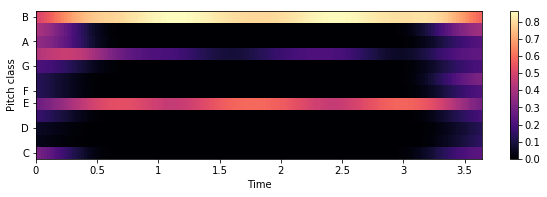

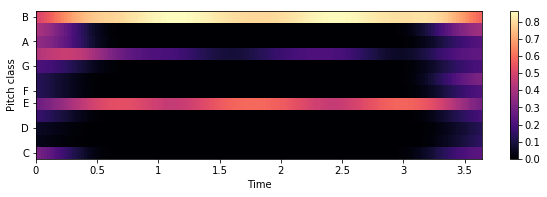

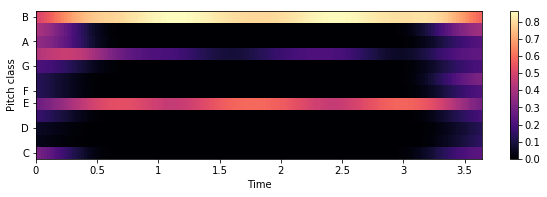

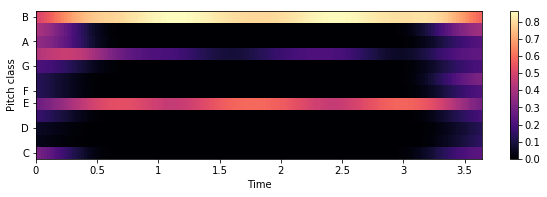

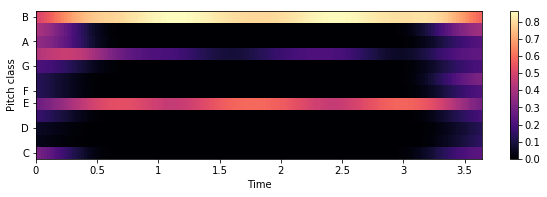

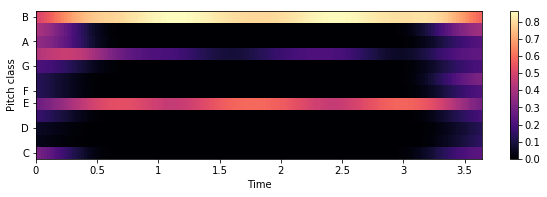

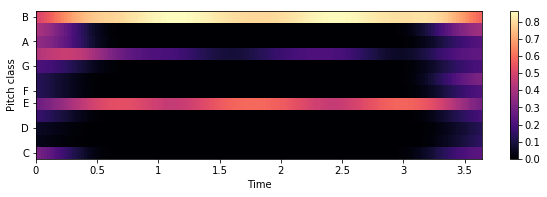

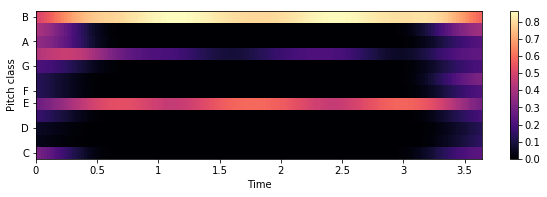

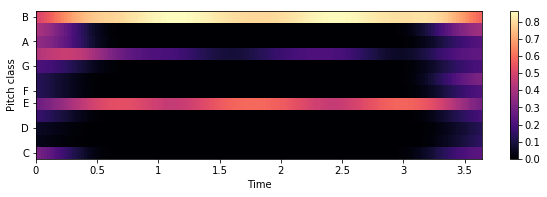

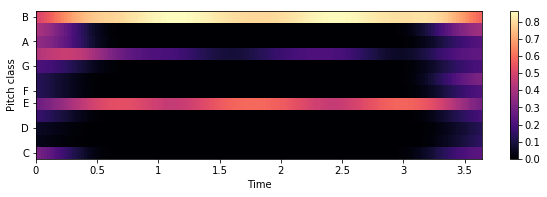

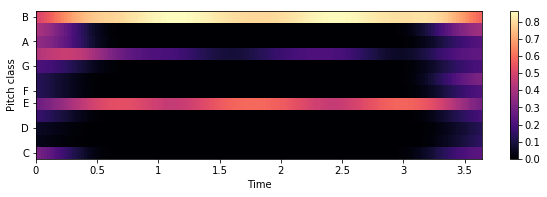

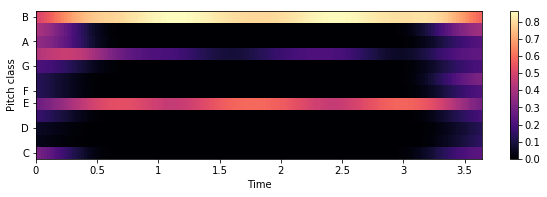

In [61]:
import numpy as np
from librosa import display
input_file = 'samples/e0.wav'
# Create templates for major, minor, and no-chord qualities
maj_template = np.array([1,0,0, 0,1,0, 0,1,0, 0,0,0])
min_template = np.array([1,0,0, 1,0,0, 0,1,0, 0,0,0])
N_template   = np.array([1,1,1, 1,1,1, 1,1,1, 1,1,1.]) / 4.
# Generate the weighting matrix that maps chroma to labels
weights = np.zeros((25, 12), dtype=float)
labels = ['C:maj', 'C#:maj', 'D:maj', 'D#:maj', 'E:maj', 'F:maj',
           'F#:maj', 'G:maj', 'G#:maj', 'A:maj', 'A#:maj', 'B:maj',
         'C:min', 'C#:min', 'D:min', 'D#:min', 'E:min', 'F:min',
         'F#:min', 'G:min', 'G#:min', 'A:min', 'A#:min', 'B:min',
         'N']
for c in range(12):
    weights[c, :] = np.roll(maj_template, c) # c:maj
    weights[c + 12, :] = np.roll(min_template, c)  # c:min
    weights[-1] = N_template  # the last row is the no-chord class
# Make a self-loop transition matrix over 25 states
    trans = librosa.sequence.transition_loop(25, 0.9)
    # Load in audio and make features
    y, sr = librosa.load(input_file)
    chroma = librosa.feature.chroma_cens(y=y, sr=sr, bins_per_octave=36)
    # Map chroma (observations) to class (state) likelihoods
    probs = np.exp(weights.dot(chroma))  # P[class | chroma] proportional to exp(template' chroma)
    probs /= probs.sum(axis=0, keepdims=True)  # probabilities must sum to 1 in each column
    # Compute independent frame-wise estimates
    chords_ind = np.argmax(probs, axis=0)
    # And viterbi estimates
    chords_vit = librosa.sequence.viterbi_discriminative(probs, trans)
    # Plot the features and prediction map
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.subplot(2,1,1)
    librosa.display.specshow(chroma, x_axis='time', y_axis='chroma')
    plt.colorbar()
#     plt.subplot(2,1,2)
#     librosa.display.specshow(weights, x_axis='chroma')
#     plt.yticks(np.arange(25) + 0.5, labels)
#     plt.ylabel('Chord')
#     plt.colorbar()
#     plt.tight_layout()
#     # And plot the results
#     plt.figure(figsize=(10, 4))
#     display.specshow(probs, x_axis='time', cmap='gray')
#     plt.colorbar()
#     times = librosa.frames_to_time(np.arange(len(chords_vit)))
#     plt.scatter(times, chords_ind + 0.75, color='lime', alpha=0.5, marker='+', s=15, label='Independent')
#     plt.scatter(times, chords_vit + 0.25, color='deeppink', alpha=0.5, marker='o', s=15, label='Viterbi')
#     plt.yticks(0.5 + np.unique(chords_vit), [labels[i] for i in np.unique(chords_vit)], va='center')
#     plt.legend(loc='best')
#     plt.tight_layout()
plt.show()

In [62]:
labels[chroma.sum(axis=1).argmax()]

'B:maj'